Categorizing a data set and applying a function to each group, whether an aggregation
or transformation, is often a critical component of a data analysis workflow. After
loading, merging, and preparing a data set, a familiar task is to compute group statistics
or possibly pivot tables for reporting or visualization purposes. pandas provides a flexible
and high-performance groupby facility, enabling you to slice and dice, and summarize
data sets in a natural way.

One reason for the popularity of relational databases and SQL (which stands for
“structured query language”) is the ease with which data can be joined, filtered, transformed,
and aggregated. However, query languages like SQL are rather limited in the
kinds of group operations that can be performed. As you will see, with the expressiveness
and power of Python and pandas, we can perform much more complex grouped
operations by utilizing any function that accepts a pandas object or NumPy array. In
this chapter, you will learn how to:

• Split a pandas object into pieces using one or more keys (in the form of functions,
arrays, or DataFrame column names)

• Computing group summary statistics, like count, mean, or standard deviation, or
a user-defined function

• Apply a varying set of functions to each column of a DataFrame

• Apply within-group transformations or other manipulations, like normalization,
linear regression, rank, or subset selection

• Compute pivot tables and cross-tabulations

• Perform quantile analysis and other data-derived group analyses

Page 251 - Page 288

## GroupBy Mechanics

Hadley Wickham, an author of many popular packages for the R programming language,
coined the term split-apply-combine for talking about group operations, and I
think that’s a good description of the process. In the first stage of the process, data
contained in a pandas object, whether a Series, DataFrame, or otherwise, is split into
groups based on one or more keys that you provide. The splitting is performed on a
particular axis of an object. For example, a DataFrame can be grouped on its rows
(axis=0) or its columns (axis=1). Once this is done, a function is applied to each group,
producing a new value. Finally, the results of all those function applications are combined
into a result object. The form of the resulting object will usually depend on what’s
being done to the data. See Figure 9-1 for a mockup of a simple group aggregation.

1. Split
2. Apply
3. Combine

Each grouping key can take many forms, and the keys do not have to be all of the same
type:

• A list or array of values that is the same length as the axis being grouped

• A value indicating a column name in a DataFrame

• A dict or Series giving a correspondence between the values on the axis being
grouped and the group names

• A function to be invoked on the axis index or the individual labels in the index

Note that the latter three methods are all just shortcuts for producing an array of values
to be used to split up the object. Don’t worry if this all seems very abstract. Throughout
this chapter, I will give many examples of all of these methods. To get started, here is
a very simple small tabular dataset as a DataFrame:

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import Series
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline


In [2]:
df = DataFrame({'key1' : ['a', 'a', 'b', 'b', 'a'],
    'key2' : ['one', 'two', 'one', 'two', 'one'],
    'data1' : np.random.randn(5),
    'data2' : np.random.randn(5)})
df

,data1,data2,key1,key2
0,1.338616,-0.970528,a,one
1,-0.316974,0.901349,a,two
2,-0.330960,0.619308,b,one
3,-1.253164,-0.835093,b,two
4,0.050359,-1.441213,a,one


Suppose you wanted to compute the mean of the data1 column using the groups labels
from key1. There are a number of ways to do this. One is to access data1 and call
groupby with the column (a Series) at key1:

In [3]:
grouped = df['data1'].groupby(df['key1'])
grouped

This grouped variable is now a GroupBy object. It has not actually computed anything
yet except for some intermediate data about the group key df['key1']. The idea is that
this object has all of the information needed to then apply some operation to each of
the groups. For example, to compute group means we can call the GroupBy’s mean
method:

In [4]:
grouped.mean()

key1
a    0.357334
b   -0.792062
Name: data1, dtype: float64

Later, I'll explain more about what’s going on when you call .mean(). The important
thing here is that the data (a Series) has been aggregated according to the group key,
producing a new Series that is now indexed by the unique values in the key1 column.
The result index has the name 'key1' because the DataFrame column df['key1'] did.
If instead we had passed multiple arrays as a list, we get something different:

In [5]:
means = df['data1'].groupby([df['key1'], df['key2']]).mean()
means

key1  key2
a     one     0.694488
      two    -0.316974
b     one    -0.330960
      two    -1.253164
Name: data1, dtype: float64

In this case, we grouped the data using two keys, and the resulting Series now has a
hierarchical index consisting of the unique pairs of keys observed:

In [6]:
means.unstack()

key2,one,two
key1,,
a,0.694488,-0.316974
b,-0.330960,-1.253164


In these examples, the group keys are all Series, though they could be any arrays of the
right length:

In [7]:
states = np.array(['Ohio', 'California', 'California', 'Ohio', 'Ohio'])

In [8]:
years = np.array([2005, 2005, 2006, 2005, 2006])

In [9]:
df['data1'].groupby([states, years]).mean()

California  2005   -0.316974
            2006   -0.330960
Ohio        2005    0.042726
            2006    0.050359
Name: data1, dtype: float64

Frequently the grouping information to be found in the same DataFrame as the data
you want to work on. In that case, you can pass column names (whether those are
strings, numbers, or other Python objects) as the group keys:

In [10]:
df

,data1,data2,key1,key2
0,1.338616,-0.970528,a,one
1,-0.316974,0.901349,a,two
2,-0.330960,0.619308,b,one
3,-1.253164,-0.835093,b,two
4,0.050359,-1.441213,a,one


In [11]:
df.groupby('key1').mean()

,data1,data2
key1,,
a,0.357334,-0.503464
b,-0.792062,-0.107892


In [12]:
df.groupby(['key1', 'key2']).mean()

data1     data2
key1 key2                    
a    one   0.694488 -1.205871
     two  -0.316974  0.901349
b    one  -0.330960  0.619308
     two  -1.253164 -0.835093

You may have noticed in the first case df.groupby('key1').mean() that there is no
key2 column in the result. Because df['key2'] is not numeric data, it is said to be a
nuisance column, which is therefore excluded from the result. By default, all of the numeric columns are aggregated, though it is possible to filter down to a subset as you’ll
see soon.

Regardless of the objective in using groupby, a generally useful GroupBy method is
size which return a Series containing group sizes:

In [13]:
df.groupby(['key1', 'key2']).size()

key1  key2
a     one     2
      two     1
b     one     1
      two     1
dtype: int64

As of this writing, any missing values in a group key will be excluded
from the result. It’s possible (and, in fact, quite likely), that by the time
you are reading this there will be an option to include the NA group in
the result.

### Iterating Over Groups

The GroupBy object supports iteration, generating a sequence of 2-tuples containing
the group name along with the chunk of data. Consider the following small example
data set:

In [14]:
for name, group in df.groupby('key1'):
    print (name)
    print (group)

a
      data1     data2 key1 key2
0  1.338616 -0.970528    a  one
1 -0.316974  0.901349    a  two
4  0.050359 -1.441213    a  one
b
      data1     data2 key1 key2
2 -0.330960  0.619308    b  one
3 -1.253164 -0.835093    b  two


In the case of multiple keys, the first element in the tuple will be a tuple of key values:

In [15]:
for (k1, k2), group in df.groupby(['key1', 'key2']):
    print (k1, k2)
    print (group)

a one
      data1     data2 key1 key2
0  1.338616 -0.970528    a  one
4  0.050359 -1.441213    a  one
a two
      data1     data2 key1 key2
1 -0.316974  0.901349    a  two
b one
     data1     data2 key1 key2
2 -0.33096  0.619308    b  one
b two
      data1     data2 key1 key2
3 -1.253164 -0.835093    b  two


Of course, you can choose to do whatever you want with the pieces of data. A recipe
you may find useful is computing a dict of the data pieces as a one-liner:

In [16]:
pieces = dict(list(df.groupby('key1')))
pieces

{'a':       data1     data2 key1 key2
 0  1.338616 -0.970528    a  one
 1 -0.316974  0.901349    a  two
 4  0.050359 -1.441213    a  one, 'b':       data1     data2 key1 key2
 2 -0.330960  0.619308    b  one
 3 -1.253164 -0.835093    b  two}

In [17]:
pieces['b']

,data1,data2,key1,key2
2,-0.330960,0.619308,b,one
3,-1.253164,-0.835093,b,two


By default groupby groups on axis=0, but you can group on any of the other axes. For
example, we could group the columns of our example df here by dtype like so:

In [18]:
df.dtypes

data1    float64
data2    float64
key1      object
key2      object
dtype: object

In [19]:
grouped = df.groupby(df.dtypes, axis = 1)

In [20]:
dict(list(grouped))

{dtype('float64'):       data1     data2
 0  1.338616 -0.970528
 1 -0.316974  0.901349
 2 -0.330960  0.619308
 3 -1.253164 -0.835093
 4  0.050359 -1.441213, dtype('O'):   key1 key2
 0    a  one
 1    a  two
 2    b  one
 3    b  two
 4    a  one}

### Selecting a Column or Subset of Columns

Indexing a GroupBy object created from a DataFrame with a column name or array of
column names has the effect of selecting those columns for aggregation. This means that:

In [21]:
df.groupby('key1')['data1']
df.groupby('key1')[['data2']]

are syntactic sugar for:

In [22]:
df['data1'].groupby(df['key1'])
df[['data2']].groupby(df['key1'])

Especially for large data sets, it may be desirable to aggregate only a few columns. For
example, in the above data set, to compute means for just the data2 column and get
the result as a DataFrame, we could write:

In [23]:
df.groupby(['key1', 'key2'])[['data2']].mean()

data2
key1 key2          
a    one  -1.205871
     two   0.901349
b    one   0.619308
     two  -0.835093

The object returned by this indexing operation is a grouped DataFrame if a list or array
is passed and a grouped Series is just a single column name that is passed as a scalar:

In [24]:
s_grouped = df.groupby(['key1', 'key2'])['data2']
s_grouped

In [25]:
s_grouped.mean()

key1  key2
a     one    -1.205871
      two     0.901349
b     one     0.619308
      two    -0.835093
Name: data2, dtype: float64

### Grouping with Dicts and Series

Grouping information may exist in a form other than an array. Let’s consider another
example DataFrame:

In [26]:
people = DataFrame(np.random.randn(5, 5),
    columns=['a', 'b', 'c', 'd', 'e'],
    index=['Joe', 'Steve', 'Wes', 'Jim', 'Travis'])
people

,a,b,c,d,e
Joe,0.784858,1.460123,-0.559975,1.371300,-0.427690
Steve,-0.377169,2.282115,1.659859,-0.496148,-0.173632
Wes,0.783731,-0.713613,-1.467918,0.482810,-1.837303
Jim,-1.044849,-0.312278,-0.338053,-0.332397,0.413058
Travis,-0.812158,-0.054137,1.117580,0.837235,-0.628016


In [27]:
# While using the ix function, the first part, e.g. 2:3 here, represent rows and 'b', 'c' represent columns.
# Skill: adding a few NAN to the DataFrame
people.ix[2:3, ['b', 'c']] = np.nan # Add a few NA values

In [28]:
people

,a,b,c,d,e
Joe,0.784858,1.460123,-0.559975,1.371300,-0.427690
Steve,-0.377169,2.282115,1.659859,-0.496148,-0.173632
Wes,0.783731,NaN,NaN,0.482810,-1.837303
Jim,-1.044849,-0.312278,-0.338053,-0.332397,0.413058
Travis,-0.812158,-0.054137,1.117580,0.837235,-0.628016


Now, suppose I have a group correspondence for the columns and want to sum together
the columns by group:

In [29]:
mapping = {'a': 'red', 'b': 'red', 'c': 'blue',
    'd': 'blue', 'e': 'red', 'f' : 'orange'}
mapping

{'a': 'red', 'b': 'red', 'c': 'blue', 'd': 'blue', 'e': 'red', 'f': 'orange'}

Now, you could easily construct an array from this dict to pass to groupby, but instead
we can just pass the dict:

In [30]:
by_column = people.groupby(mapping, axis = 1)
by_column.sum()

,blue,red
Joe,0.811325,1.817291
Steve,1.163711,1.731314
Wes,0.482810,-1.053571
Jim,-0.670450,-0.944070
Travis,1.954814,-1.494312


The same functionality holds for Series, which can be viewed as a fixed size mapping.
When I used Series as group keys in the above examples, pandas does, in fact, inspect
each Series to ensure that its index is aligned with the axis it’s grouping:

In [31]:
map_series = Series(mapping)

In [32]:
map_series

a       red
b       red
c      blue
d      blue
e       red
f    orange
dtype: object

In [33]:
people.groupby(map_series, axis=1).count()

,blue,red
Joe,2,3
Steve,2,3
Wes,1,2
Jim,2,3
Travis,2,3


In [34]:
people.groupby(map_series, axis = 0).count()

,a,b,c,d,e


### Grouping with Functions

Using Python functions in what can be fairly creative ways is a more abstract way of
defining a group mapping compared with a dict or Series. Any function passed as a
group key will be called once per index value, with the return values being used as the
group names. More concretely, consider the example DataFrame from the previous
section, which has people’s first names as index values. Suppose you wanted to group
by the length of the names; you could compute an array of string lengths, but instead
you can just pass the len function:

In [35]:
people

,a,b,c,d,e
Joe,0.784858,1.460123,-0.559975,1.371300,-0.427690
Steve,-0.377169,2.282115,1.659859,-0.496148,-0.173632
Wes,0.783731,NaN,NaN,0.482810,-1.837303
Jim,-1.044849,-0.312278,-0.338053,-0.332397,0.413058
Travis,-0.812158,-0.054137,1.117580,0.837235,-0.628016


In [36]:
# Group by the length of the names
people.groupby(len).sum()

,a,b,c,d,e
3,0.523740,1.147845,-0.898029,1.521713,-1.851935
5,-0.377169,2.282115,1.659859,-0.496148,-0.173632
6,-0.812158,-0.054137,1.117580,0.837235,-0.628016


Mixing functions with arrays, dicts, or Series is not a problem as everything gets converted
to arrays internally:

In [37]:
# Actually this process is the same as assigning these five keys to the five names above, representing each loc.
key_list = ['one', 'one','one', 'two', 'two']

In [38]:
# Try not to get confused by clarrifying the priority of looking at indexes, e.g., first locate the names with the 
# length of 3, then locate the names assigned with one or two.
people.groupby([len, key_list]).min()

a         b         c         d         e
3 one  0.783731  1.460123 -0.559975  0.482810 -1.837303
  two -1.044849 -0.312278 -0.338053 -0.332397  0.413058
5 one -0.377169  2.282115  1.659859 -0.496148 -0.173632
6 two -0.812158 -0.054137  1.117580  0.837235 -0.628016

### Grouping by Index Levels

A final convenience for hierarchically-indexed data sets is the ability to aggregate using
one of the levels of an axis index. To do this, pass the level number or name using the
level keyword:

In [39]:
columns = pd.MultiIndex.from_arrays([['US', 'US', 'US', 'JP', 'JP'],
    [1, 3, 5, 1, 3]], names=['cty', 'tenor'])

In [40]:
hier_df = DataFrame(np.random.randn(4, 5), columns=columns)

In [41]:
hier_df

cty          US                            JP          
tenor         1         3         5         1         3
0     -0.322530  0.739361 -2.825683 -2.373997  0.269507
1      1.157915  0.962480 -0.849841  0.997671 -0.536824
2     -0.700416  0.233876  1.096628 -1.350266 -0.304858
3      0.825363  0.854046  0.328126  0.737949 -1.454393

In [42]:
# Try another one - Brad's Pratice:
# Use the pd.MultiIndex.from_arrays to generate a dataframe with hieracical indexes
columns1 = pd.MultiIndex.from_arrays([['US', 'US', 'US', 'GB','GB'],
                                     ['NY', 'NJ', 'CA', 'LDN', 'BM']], names = ['Countries', 'Areas/States'])
h1 = DataFrame(np.random.randn(4, 5), columns = columns1)
h1

Countries           US                            GB          
Areas/States        NY        NJ        CA       LDN        BM
0            -0.200130 -0.949690  1.311640  1.306971  0.030964
1            -0.673440  0.286142 -0.170841  0.787712 -0.363475
2            -1.299987  0.780264 -1.688002 -0.641395  0.754528
3            -1.038858  1.454633 -0.825964 -0.320063 -0.094055

In [43]:
# Let's continue with the textbook content using my own dataframe.
# Goal is to count how many states/areas do each Country have in this dataframe.
h1.groupby(level = 'Countries', axis = 1).count()

Countries,GB,US
0,2,3
1,2,3
2,2,3
3,2,3


## Data Aggregation

By aggregation, I am generally referring to any data transformation that produces scalar
values from arrays. In the examples above I have used several of them, such as mean,
count, min and sum. You may wonder what is going on when you invoke mean() on a
GroupBy object. Many common aggregations, such as those found in Table 9-1, have
optimized implementations that compute the statistics on the dataset in place. However,
you are not limited to only this set of methods. You can use aggregations of your own devising and additionally call any method that is also defined on the grouped
object. For example, as you recall quantile computes sample quantiles of a Series or a
DataFrame’s columns 1:

In [44]:
df

,data1,data2,key1,key2
0,1.338616,-0.970528,a,one
1,-0.316974,0.901349,a,two
2,-0.330960,0.619308,b,one
3,-1.253164,-0.835093,b,two
4,0.050359,-1.441213,a,one


In [45]:
# Goal is to cal the 99% quantile for values grouped by a and b
grouped = df.groupby('key1')

In [46]:
grouped['data1'].quantile(0.99)

key1
a    1.312850
b   -0.340182
Name: data1, dtype: float64

While quantile is not explicitly implemented for GroupBy, it is a Series method and
thus available for use. Internally, GroupBy efficiently slices up the Series, calls
piece.quantile(0.9) for each piece, then assembles those results together into the result
object.

To use your own aggregation functions, pass any function that aggregates an array to
the aggregate or agg method:

In [47]:
def peak_to_peak(arr):
    return arr.max() - arr.min()

In [48]:
grouped.agg(peak_to_peak)

,data1,data2
key1,,
a,1.655590,2.342561
b,0.922204,1.454401


You’ll notice that some methods like describe also work, even though they are not
aggregations, strictly speaking:

In [49]:
grouped.describe()

data1     data2
key1                          
a    count  3.000000  3.000000
     mean   0.357334 -0.503464
     std    0.869436  1.239157
     min   -0.316974 -1.441213
     25%   -0.133307 -1.205871
     50%    0.050359 -0.970528
     75%    0.694488 -0.034590
     max    1.338616  0.901349
b    count  2.000000  2.000000
     mean  -0.792062 -0.107892
     std    0.652097  1.028417
     min   -1.253164 -0.835093
     25%   -1.022613 -0.471493
     50%   -0.792062 -0.107892
     75%   -0.561511  0.255708
     max   -0.330960  0.619308

I will explain in more detail what has happened here in the next major section on groupwise
operations and transformations.

You may notice that custom aggregation functions are much slower than
the optimized functions found in Table 9-1. This is because there is
significant overhead (function calls, data rearrangement) in constructing
the intermediate group data chunks.

Table 9-1. Optimized groupby methods

Function name Description


count: Number of non-NA values in the group

sum: Sum of non-NA values

mean: Mean of non-NA values

median: Arithmetic median of non-NA values

std, var: Unbiased (n - 1 denominator) standard deviation and variance

min, max: Minimum and maximum of non-NA values

prod: Product of non-NA values

first, last: First and last non-NA values

To illustrate some more advanced aggregation features, I’ll use a less trivial dataset, a
dataset on restaurant tipping. I obtained it from the R reshape2 package; it was originally
found in Bryant & Smith’s 1995 text on business statistics (and found in the book’s
GitHub repository). After loading it with read_csv, I add a tipping percentage column
tip_pct.

In [50]:
tips = pd.read_csv('tips.csv')

In [51]:
# Add tip percentage of total bill
tips['tip_pct'] = tips['tip']/tips['total_bill']

tips[:6]

,total_bill,tip,sex,smoker,day,time,size,tip_pct
0,16.99,1.01,Female,No,Sun,Dinner,2,0.059447
1,10.34,1.66,Male,No,Sun,Dinner,3,0.160542
2,21.01,3.50,Male,No,Sun,Dinner,3,0.166587
3,23.68,3.31,Male,No,Sun,Dinner,2,0.139780
4,24.59,3.61,Female,No,Sun,Dinner,4,0.146808
5,25.29,4.71,Male,No,Sun,Dinner,4,0.186240


### Column-wise and Multiple Function Application

As you’ve seen above, aggregating a Series or all of the columns of a DataFrame is a
matter of using aggregate with the desired function or calling a method like mean or
std. However, you may want to aggregate using a different function depending on the
column or multiple functions at once. Fortunately, this is straightforward to do, which
I’ll illustrate through a number of examples. First, I’ll group the tips by sex and smoker:

In [52]:
grouped = tips.groupby(['sex', 'smoker'])

Note that for descriptive statistics like those in Table 9-1, you can pass the name of the
function as a string:

In [53]:
grouped_pct = grouped['tip_pct']

In [54]:
grouped_pct.agg('mean')

sex     smoker
Female  No        0.156921
        Yes       0.182150
Male    No        0.160669
        Yes       0.152771
Name: tip_pct, dtype: float64

If you pass a list of functions or function names instead, you get back a DataFrame with
column names taken from the functions:

In [55]:
grouped_pct.agg(['mean', 'std', peak_to_peak])

mean       std  peak_to_peak
sex    smoker                                  
Female No      0.156921  0.036421      0.195876
       Yes     0.182150  0.071595      0.360233
Male   No      0.160669  0.041849      0.220186
       Yes     0.152771  0.090588      0.674707

You don’t need to accept the names that GroupBy gives to the columns; notably
lambda functions have the name '<lambda>' which make them hard to identify (you can
see for yourself by looking at a function’s  __name__  attribute). As such, if you pass a list
of (name, function) tuples, the first element of each tuple will be used as the DataFrame
column names (you can think of a list of 2-tuples as an ordered mapping):

In [56]:
grouped_pct.agg([('foo', 'mean'), ('bar', np.std)])

foo       bar
sex    smoker                    
Female No      0.156921  0.036421
       Yes     0.182150  0.071595
Male   No      0.160669  0.041849
       Yes     0.152771  0.090588

With a DataFrame, you have more options as you can specify a list of functions to apply
to all of the columns or different functions per column. To start, suppose we wanted
to compute the same three statistics for the tip_pct and total_bill columns:

In [57]:
functions = ['count', 'mean', 'max']

In [58]:
result = grouped['tip_pct', 'total_bill'].agg(functions)

In [59]:
result

tip_pct                     total_bill                  
                count      mean       max      count       mean    max
sex    smoker                                                         
Female No          54  0.156921  0.252672         54  18.105185  35.83
       Yes         33  0.182150  0.416667         33  17.977879  44.30
Male   No          97  0.160669  0.291990         97  19.791237  48.33
       Yes         60  0.152771  0.710345         60  22.284500  50.81

As you can see, the resulting DataFrame has hierarchical columns, the same as you
would get aggregating each column separately and using concat to glue the results
together using the column names as the keys argument:

In [60]:
result['tip_pct']

count      mean       max
sex    smoker                           
Female No         54  0.156921  0.252672
       Yes        33  0.182150  0.416667
Male   No         97  0.160669  0.291990
       Yes        60  0.152771  0.710345

As above, a list of tuples with custom names can be passed:

In [61]:
ftuples = [('Durchschnitt', 'mean'), ('Abweichung', np.var)]

In [62]:
grouped['tip_pct', 'total_bill'].agg(ftuples)

tip_pct              total_bill           
              Durchschnitt Abweichung Durchschnitt Abweichung
sex    smoker                                                
Female No         0.156921   0.001327    18.105185  53.092422
       Yes        0.182150   0.005126    17.977879  84.451517
Male   No         0.160669   0.001751    19.791237  76.152961
       Yes        0.152771   0.008206    22.284500  98.244673

Now, suppose you wanted to apply potentially different functions to one or more of
the columns. The trick is to pass a dict to agg that contains a mapping of column names
to any of the function specifications listed so far:

In [63]:
# Show tips again
tips.head(10)

,total_bill,tip,sex,smoker,day,time,size,tip_pct
0,16.99,1.01,Female,No,Sun,Dinner,2,0.059447
1,10.34,1.66,Male,No,Sun,Dinner,3,0.160542
2,21.01,3.50,Male,No,Sun,Dinner,3,0.166587
3,23.68,3.31,Male,No,Sun,Dinner,2,0.139780
4,24.59,3.61,Female,No,Sun,Dinner,4,0.146808
5,25.29,4.71,Male,No,Sun,Dinner,4,0.186240
6,8.77,2.00,Male,No,Sun,Dinner,2,0.228050
7,26.88,3.12,Male,No,Sun,Dinner,4,0.116071
8,15.04,1.96,Male,No,Sun,Dinner,2,0.130319
9,14.78,3.23,Male,No,Sun,Dinner,2,0.218539


In [64]:
grouped.agg({'tip': np.max, 'size': 'sum'})

tip  size
sex    smoker            
Female No       5.2   140
       Yes      6.5    74
Male   No       9.0   263
       Yes     10.0   150

In [65]:
grouped.agg({'tip_pct': ['min', 'max', 'mean', 'std'],
            'size': 'sum'})

tip_pct                               size
                    min       max      mean       std  sum
sex    smoker                                             
Female No      0.056797  0.252672  0.156921  0.036421  140
       Yes     0.056433  0.416667  0.182150  0.071595   74
Male   No      0.071804  0.291990  0.160669  0.041849  263
       Yes     0.035638  0.710345  0.152771  0.090588  150

A DataFrame will have hierarchical columns only if multiple functions are applied to
at least one column.

### Returning Aggregated Data in "unindexed" Form

In all of the examples up until now, the aggregated data comes back with an index,
potentially hierarchical, composed from the unique group key combinations observed.
Since this isn’t always desirable, you can disable this behavior in most cases by passing
as_index=False to groupby:

In [66]:
tips.groupby(['sex', 'smoker'], as_index = False).mean()

,sex,smoker,total_bill,tip,size,tip_pct
0,Female,No,18.105185,2.773519,2.592593,0.156921
1,Female,Yes,17.977879,2.931515,2.242424,0.182150
2,Male,No,19.791237,3.113402,2.711340,0.160669
3,Male,Yes,22.284500,3.051167,2.500000,0.152771


In [67]:
#As a contrast, we show as follows:
tips.groupby(['sex', 'smoker'], as_index = True).mean()

total_bill       tip      size   tip_pct
sex    smoker                                          
Female No       18.105185  2.773519  2.592593  0.156921
       Yes      17.977879  2.931515  2.242424  0.182150
Male   No       19.791237  3.113402  2.711340  0.160669
       Yes      22.284500  3.051167  2.500000  0.152771

Of course, it’s always possible to obtain the result in this format by calling
reset_index on the result.

Using groupby in this way is generally less flexible; results with hierarchical
columns, for example, are not currently implemented as the
form of the result would have to be somewhat arbitrary.

## Group-wise Operations and Transformations

Aggregation is only one kind of group operation. It is a special case in the more general
class of data transformations; that is, it accepts functions that reduce a one-dimensional
array to a scalar value. In this section, I will introduce you to the transform and apply
methods, which will enable you to do many other kinds of group operations.

Suppose, instead, we wanted to add a column to a DataFrame containing group means
for each index. One way to do this is to aggregate, then merge:

In [68]:
df

,data1,data2,key1,key2
0,1.338616,-0.970528,a,one
1,-0.316974,0.901349,a,two
2,-0.330960,0.619308,b,one
3,-1.253164,-0.835093,b,two
4,0.050359,-1.441213,a,one


In [69]:
k1_means = df.groupby('key1').mean().add_prefix('mean_')
k1_means

,mean_data1,mean_data2
key1,,
a,0.357334,-0.503464
b,-0.792062,-0.107892


In [70]:
pd.merge(df, k1_means, left_on='key1', right_index=True)

,data1,data2,key1,key2,mean_data1,mean_data2
0,1.338616,-0.970528,a,one,0.357334,-0.503464
1,-0.316974,0.901349,a,two,0.357334,-0.503464
4,0.050359,-1.441213,a,one,0.357334,-0.503464
2,-0.330960,0.619308,b,one,-0.792062,-0.107892
3,-1.253164,-0.835093,b,two,-0.792062,-0.107892


In [71]:
# Show the difference between using merge and concat, the latter of which seems to violently combine two dataframe 
pd.concat([df, k1_means])

,data1,data2,key1,key2,mean_data1,mean_data2
0,1.338616,-0.970528,a,one,NaN,NaN
1,-0.316974,0.901349,a,two,NaN,NaN
2,-0.330960,0.619308,b,one,NaN,NaN
3,-1.253164,-0.835093,b,two,NaN,NaN
4,0.050359,-1.441213,a,one,NaN,NaN
a,NaN,NaN,NaN,NaN,0.357334,-0.503464
b,NaN,NaN,NaN,NaN,-0.792062,-0.107892


This works, but is somewhat inflexible. You can think of the operation as transforming
the two data columns using the np.mean function. Let’s look back at the people Data-
Frame from earlier in the chapter and use the transform method on GroupBy:

In [72]:
key = ['one', 'two', 'one', 'two', 'one']

In [73]:
people.groupby(key).mean()

,a,b,c,d,e
one,0.252144,0.702993,0.278802,0.897115,-0.964336
two,-0.711009,0.984918,0.660903,-0.414272,0.119713


In [74]:
# Transform back to before 'key' was assigned and take the means grouped by key.
people.groupby(key).transform(np.mean)

,a,b,c,d,e
Joe,0.252144,0.702993,0.278802,0.897115,-0.964336
Steve,-0.711009,0.984918,0.660903,-0.414272,0.119713
Wes,0.252144,0.702993,0.278802,0.897115,-0.964336
Jim,-0.711009,0.984918,0.660903,-0.414272,0.119713
Travis,0.252144,0.702993,0.278802,0.897115,-0.964336


As you may guess, transform applies a function to each group, then places the results
in the appropriate locations. If each group produces a scalar value, it will be propagated
(broadcasted). Suppose instead you wanted to subtract the mean value from each
group. To do this, create a demeaning function and pass it to transform:

In [75]:
def demean(arr):
    return arr - arr.mean()

In [76]:
demeaned = people.groupby(key).transform(demean)
demeaned

,a,b,c,d,e
Joe,0.532714,0.757130,-0.838778,0.474185,0.536646
Steve,0.333840,1.297197,0.998956,-0.081876,-0.293345
Wes,0.531587,NaN,NaN,-0.414305,-0.872966
Jim,-0.333840,-1.297197,-0.998956,0.081876,0.293345
Travis,-1.064302,-0.757130,0.838778,-0.059880,0.336320


You can check that demeaned now has zero group means:

In [77]:
#Question: why not exactly 0?
demeaned.groupby(key).mean()

,a,b,c,d,e
one,0.000000e+00,-5.551115e-17,0.0,-1.850372e-17,0.0
two,-2.775558e-17,0.000000e+00,0.0,-2.775558e-17,0.0


### Apply: General split-apply-combine

Like aggregate, transform is a more specialized function having rigid requirements: the
passed function must either produce a scalar value to be broadcasted (like np.mean) or
a transformed array of the same size. The most general purpose GroupBy method is
apply, which is the subject of the rest of this section. As in Figure 9-1, apply splits the
object being manipulated into pieces, invokes the passed function on each piece, then
attempts to concatenate the pieces together.

Returning to the tipping data set above, suppose you wanted to select the top five
tip_pct values by group. First, it’s straightforward to write a function that selects the
rows with the largest values in a particular column:

In [78]:
def top(df, n=5, column = 'tip_pct'):
    return df.sort_index(by = column)[-n:]

In [79]:
top(tips, n=5)

C:\Users\Brad Sun\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  from ipykernel import kernelapp as app


,total_bill,tip,sex,smoker,day,time,size,tip_pct
183,23.17,6.50,Male,Yes,Sun,Dinner,4,0.280535
232,11.61,3.39,Male,No,Sat,Dinner,2,0.291990
67,3.07,1.00,Female,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Female,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Male,Yes,Sun,Dinner,2,0.710345


Now, if we group by smoker, say, and call apply with this function, we get the following:

In [80]:
tips.groupby('smoker').apply(top)

C:\Users\Brad Sun\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  from ipykernel import kernelapp as app


total_bill   tip     sex smoker   day    time  size   tip_pct
smoker                                                                   
No     88        24.71  5.85    Male     No  Thur   Lunch     2  0.236746
       185       20.69  5.00    Male     No   Sun  Dinner     5  0.241663
       51        10.29  2.60  Female     No   Sun  Dinner     2  0.252672
       149        7.51  2.00    Male     No  Thur   Lunch     2  0.266312
       232       11.61  3.39    Male     No   Sat  Dinner     2  0.291990
Yes    109       14.31  4.00  Female    Yes   Sat  Dinner     2  0.279525
       183       23.17  6.50    Male    Yes   Sun  Dinner     4  0.280535
       67         3.07  1.00  Female    Yes   Sat  Dinner     1  0.325733
       178        9.60  4.00  Female    Yes   Sun  Dinner     2  0.416667
       172        7.25  5.15    Male    Yes   Sun  Dinner     2  0.710345

What has happened here? The top function is called on each piece of the DataFrame,
then the results are glued together using pandas.concat, labeling the pieces with the
group names. The result therefore has a hierarchical index whose inner level contains
index values from the original DataFrame

If you pass a function to apply that takes other arguments or keywords, you can pass
these after the function:

In [81]:
tips.groupby(['smoker', 'day']).apply(top, n=1, column = 'total_bill')

C:\Users\Brad Sun\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  from ipykernel import kernelapp as app


total_bill    tip     sex smoker   day    time  size  \
smoker day                                                              
No     Fri  94        22.75   3.25  Female     No   Fri  Dinner     2   
       Sat  212       48.33   9.00    Male     No   Sat  Dinner     4   
       Sun  156       48.17   5.00    Male     No   Sun  Dinner     6   
       Thur 142       41.19   5.00    Male     No  Thur   Lunch     5   
Yes    Fri  95        40.17   4.73    Male    Yes   Fri  Dinner     4   
       Sat  170       50.81  10.00    Male    Yes   Sat  Dinner     3   
       Sun  182       45.35   3.50    Male    Yes   Sun  Dinner     3   
       Thur 197       43.11   5.00  Female    Yes  Thur   Lunch     4   

                  tip_pct  
smoker day                 
No     Fri  94   0.142857  
       Sat  212  0.186220  
       Sun  156  0.103799  
       Thur 142  0.121389  
Yes    Fri  95   0.117750  
       Sat  170  0.196812  
       Sun  182  0.077178  
       Thur 197  0.115982

Beyond these basic usage mechanics, getting the most out of apply is
largely a matter of creativity. What occurs inside the function passed is
up to you; it only needs to return a pandas object or a scalar value. The
rest of this chapter will mainly consist of examples showing you how to
solve various problems using groupby.

You may recall above I called describe on a GroupBy object:

In [82]:
result = tips.groupby('smoker')['tip_pct'].describe()
result

smoker       
No      count    151.000000
        mean       0.159328
        std        0.039910
        min        0.056797
        25%        0.136906
        50%        0.155625
        75%        0.185014
        max        0.291990
Yes     count     93.000000
        mean       0.163196
        std        0.085119
        min        0.035638
        25%        0.106771
        50%        0.153846
        75%        0.195059
        max        0.710345
Name: tip_pct, dtype: float64

In [83]:
result.unstack('smoker')

smoker,No,Yes
count,151.000000,93.000000
mean,0.159328,0.163196
std,0.039910,0.085119
min,0.056797,0.035638
25%,0.136906,0.106771
50%,0.155625,0.153846
75%,0.185014,0.195059
max,0.291990,0.710345


Inside GroupBy, when you invoke a method like describe, it is actually just a shortcut
for:

In [84]:
f = lambda x: x.describe()
grouped.apply(f)

total_bill        tip       size    tip_pct
sex    smoker                                                   
Female No     count   54.000000  54.000000  54.000000  54.000000
              mean    18.105185   2.773519   2.592593   0.156921
              std      7.286455   1.128425   1.073146   0.036421
              min      7.250000   1.000000   1.000000   0.056797
              25%     12.650000   2.000000   2.000000   0.139708
              50%     16.690000   2.680000   2.000000   0.149691
              75%     20.862500   3.437500   3.000000   0.181630
              max     35.830000   5.200000   6.000000   0.252672
       Yes    count   33.000000  33.000000  33.000000  33.000000
              mean    17.977879   2.931515   2.242424   0.182150
              std      9.189751   1.219916   0.613917   0.071595
              min      3.070000   1.000000   1.000000   0.056433
              25%     12.760000   2.000000   2.000000   0.152439
              50%     16.270000   2.880000   2.000000   0.173913
              75%     22.120000   3.500000   2.000000   0.198216
              max     44.300000   6.500000   4.000000   0.416667
Male   No     count   97.000000  97.000000  97.000000  97.000000
              mean    19.791237   3.113402   2.711340   0.160669
              std      8.726566   1.489559   0.989094   0.041849
              min      7.510000   1.250000   2.000000   0.071804
              25%     13.810000   2.000000   2.000000   0.131810
              50%     18.240000   2.740000   2.000000   0.157604
              75%     22.820000   3.710000   3.000000   0.186220
              max     48.330000   9.000000   6.000000   0.291990
       Yes    count   60.000000  60.000000  60.000000  60.000000
              mean    22.284500   3.051167   2.500000   0.152771
              std      9.911845   1.500120   0.892530   0.090588
              min      7.250000   1.000000   1.000000   0.035638
              25%     15.272500   2.000000   2.000000   0.101845
              50%     20.390000   3.000000   2.000000   0.141015
              75%     28.572500   3.820000   3.000000   0.191697
              max     50.810000  10.000000   5.000000   0.710345

#### Suppressing the Group Keys

In the examples above, you see that the resulting object has a hierarchical index formed
from the group keys along with the indexes of each piece of the original object. This
can be disabled by passing group_keys=False to groupby:

In [85]:
tips.groupby('smoker', group_keys = False).apply(top)

C:\Users\Brad Sun\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  from ipykernel import kernelapp as app


,total_bill,tip,sex,smoker,day,time,size,tip_pct
88,24.71,5.85,Male,No,Thur,Lunch,2,0.236746
185,20.69,5.00,Male,No,Sun,Dinner,5,0.241663
51,10.29,2.60,Female,No,Sun,Dinner,2,0.252672
149,7.51,2.00,Male,No,Thur,Lunch,2,0.266312
232,11.61,3.39,Male,No,Sat,Dinner,2,0.291990
109,14.31,4.00,Female,Yes,Sat,Dinner,2,0.279525
183,23.17,6.50,Male,Yes,Sun,Dinner,4,0.280535
67,3.07,1.00,Female,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Female,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Male,Yes,Sun,Dinner,2,0.710345


### Quartile and Bucket Analysis

As you may recall from Chapter 7, pandas has some tools, in particular cut and qcut,
for slicing data up into buckets with bins of your choosing or by sample quantiles.
Combining these functions with groupby, it becomes very simple to perform bucket or quantile analysis on a data set. Consider a simple random data set and an equal-length
bucket categorization using cut:

In [86]:
frame = DataFrame({'data1': np.random.randn(1000),
                    'data2': np.random.randn(1000)})
frame

,data1,data2
0,0.596732,-2.020648
1,-0.998710,2.271985
2,1.128638,0.710328
3,0.782697,-0.581748
4,-0.343840,1.085359
5,-1.481917,-3.382551
6,-0.842035,-0.492042
7,-0.257033,-0.758553
8,-1.257701,1.337361
9,0.941372,0.909906


In [87]:
factor = pd.cut(frame.data1, 4)
factor[:10]

0     (0.0433, 1.398]
1    (-1.312, 0.0433]
2     (0.0433, 1.398]
3     (0.0433, 1.398]
4    (-1.312, 0.0433]
5    (-2.672, -1.312]
6    (-1.312, 0.0433]
7    (-1.312, 0.0433]
8    (-1.312, 0.0433]
9     (0.0433, 1.398]
Name: data1, dtype: category
Categories (4, object): [(-2.672, -1.312] < (-1.312, 0.0433] < (0.0433, 1.398] < (1.398, 2.753]]

The Factor object returned by cut can be passed directly to groupby. So we could compute
a set of statistics for the data2 column like so:

In [88]:
def get_stats(group):
    return {'min':group.min(), 'max': group.max(),
           'count': group.count(), 'mean': group.mean()}

In [89]:
grouped = frame.data2.groupby(factor)

In [90]:
grouped.apply(get_stats).unstack()

,count,max,mean,min
data1,,,,
"(-2.672, -1.312]",97.0,2.580916,-0.178396,-3.382551
"(-1.312, 0.0433]",420.0,2.980070,-0.041991,-3.153077
"(0.0433, 1.398]",400.0,2.480775,-0.048905,-2.577535
"(1.398, 2.753]",83.0,2.157768,0.041074,-2.137959


These were equal-length buckets; to compute equal-size buckets based on sample
quantiles, use qcut. I’ll pass labels=False to just get quantile numbers.

In [91]:
# Return quantile numbers
grouping = pd.qcut(frame.data1, 10, labels = False)

In [92]:
grouped = frame.data2.groupby(grouping)
grouped.apply(get_stats).unstack()

,count,max,mean,min
data1,,,,
0,100.0,2.580916,-0.182394,-3.382551
1,100.0,2.662543,-0.116477,-2.161068
2,100.0,2.926015,0.007813,-3.153077
3,100.0,2.980070,-0.010363,-1.938567
4,100.0,2.617005,-0.001158,-1.772746
5,100.0,2.096967,-0.061995,-2.008810
6,100.0,2.416153,-0.089735,-2.577535
7,100.0,2.191081,-0.115754,-2.135064
8,100.0,2.480775,0.021572,-2.213345


### Example: Filling Missing Values with Group-Specific values

When cleaning up missing data, in some cases you will filter out data observations
using dropna, but in others you may want to impute (fill in) the NA values using a fixed
value or some value derived from the data. fillna is the right tool to use; for example
here I fill in NA values with the mean:

In [93]:
s = Series(np.random.randn(6))
s

0   -0.480918
1   -1.079981
2    0.802855
3    0.829927
4   -0.526538
5    0.025089
dtype: float64

In [94]:
s[::2] = np.nan
s[::2]

0   NaN
2   NaN
4   NaN
dtype: float64

In [95]:
s

0         NaN
1   -1.079981
2         NaN
3    0.829927
4         NaN
5    0.025089
dtype: float64

In [96]:
s.fillna(s.mean())

0   -0.074988
1   -1.079981
2   -0.074988
3    0.829927
4   -0.074988
5    0.025089
dtype: float64

Suppose you need the fill value to vary by group. As you may guess, you need only
group the data and use apply with a function that calls fillna on each data chunk. Here
is some sample data on some US states divided into eastern and western states:

In [97]:
states = ['Ohio', 'New York', 'Vermont', 'Florida',
    'Oregon', 'Nevada', 'California', 'Idaho']

In [98]:
states

['Ohio',
 'New York',
 'Vermont',
 'Florida',
 'Oregon',
 'Nevada',
 'California',
 'Idaho']

In [99]:
group_key = ['East']*4 + ['West']*4
group_key

['East', 'East', 'East', 'East', 'West', 'West', 'West', 'West']

In [100]:
data = Series(np.random.randn(8), index = states)
data

Ohio          1.214545
New York     -0.300492
Vermont       0.753714
Florida      -0.744467
Oregon       -0.646278
Nevada       -0.437497
California   -1.242652
Idaho         0.636589
dtype: float64

In [101]:
data[['Vermont', 'Nevada', 'Idaho']] = np.nan

In [102]:
data

Ohio          1.214545
New York     -0.300492
Vermont            NaN
Florida      -0.744467
Oregon       -0.646278
Nevada             NaN
California   -1.242652
Idaho              NaN
dtype: float64

In [103]:
data.groupby(group_key).mean()

East    0.056529
West   -0.944465
dtype: float64

We can fill the NA values using the group means like so:

In [104]:
fill_mean = lambda g:g.fillna(g.mean())

In [105]:
data.groupby(group_key).apply(fill_mean)

Ohio          1.214545
New York     -0.300492
Vermont       0.056529
Florida      -0.744467
Oregon       -0.646278
Nevada       -0.944465
California   -1.242652
Idaho        -0.944465
dtype: float64

In another case, you might have pre-defined fill values in your code that vary by group.
Since the groups have a name attribute set internally, we can use that:

In [106]:
fill_values = {'East':0.5, 'West':-1}
fill_func = lambda g: g.fillna(fill_values[g.name])

In [107]:
data.groupby(group_key).apply(fill_func)

Ohio          1.214545
New York     -0.300492
Vermont       0.500000
Florida      -0.744467
Oregon       -0.646278
Nevada       -1.000000
California   -1.242652
Idaho        -1.000000
dtype: float64

### Example: Random Sampling and Permutation (Unfinished and Questioned)

Suppose you wanted to draw a random sample (with or without replacement) from a
large dataset for Monte Carlo simulation purposes or some other application. There
are a number of ways to perform the “draws”; some are much more efficient than others.
One way is to select the first K elements of np.random.permutation(N), where N is the
size of your complete dataset and K the desired sample size. As a more fun example,
here’s a way to construct a deck of English-style playing cards:

In [108]:
# Hearts, Spades, Clubs, Diamonds
suits = ['H', 'S', 'C', 'D']
card_val = list((range(1,11) + [10] * 3) * 4)
base_names = ['A'] + (range(2,11) + ['J', 'K', 'Q']
cards = []
                      
# Here I changed the way range is added by putting list into it but not sure if it is true.

SyntaxError: invalid syntax (<ipython-input-108-05c26bb95bb7>, line 5)

In [110]:
for suit in ['H', 'S', 'C', 'D']:
    card.extend(str(num) + suit for num in base_names)

deck = Series(card_val, index = card)

NameError: name 'card' is not defined

So now we have a Series of length 52 whose index contains card names and values are
the ones used in blackjack and other games (to keep things simple, I just let the ace be
1):

In [ ]:
deck[:13]

Now, based on what I said above, drawing a hand of 5 cards from the desk could be
written as:

In [ ]:
def draw(deck, n=5):
    return deck.take(np.random.permutation(len(deck))[:n])

In [ ]:
draw(deck)

Suppose you wanted two random cards from each suit. Because the suit is the last
character of each card name, we can group based on this and use apply:

In [ ]:
get_suit = lambda card: card[-1] #last letter is suit

deck.groupby(get_suit).apply(draw, n = 2)

In [ ]:
# alternatively
deck.groupby(get_suit, group_keys=False).apply(draw, n=2)

### Example: Group-weighted Average and Correlation

Under the split-apply-combine paradigm of groupby, operations between columns in a
DataFrame or two Series, such a group weighted average, become a routine affair. As
an example, take this dataset containing group keys, values, and some weights:

In [111]:
df = DataFrame({'category': ['a', 'a', 'a', 'a', 'b', 'b', 'b', 'b'],
    'data': np.random.randn(8),
    'weights': np.random.rand(8)})

In [112]:
df

,category,data,weights
0,a,-1.794157,0.225656
1,a,-0.483273,0.855874
2,a,-1.475810,0.746923
3,a,0.786069,0.554899
4,b,0.059201,0.010828
5,b,0.234089,0.476296
6,b,0.254373,0.895737
7,b,-0.216692,0.623374


The group weighted average by category would then be:

In [113]:
grouped = df.groupby('category')

In [114]:
get_wavg = lambda g: np.average(g['data'], weights = g['weights'])

In [115]:
grouped.apply(get_wavg)

category
a   -0.622909
b    0.102135
dtype: float64

As a less trivial example, consider a data set from Yahoo! Finance containing end of
day prices for a few stocks and the S&P 500 index (the SPX ticker):

In [116]:
close_px = pd.read_csv('stock_px.csv', parse_dates=True, index_col=0)

In [117]:
close_px[-4:]

,AAPL,MSFT,XOM,SPX
2011-10-11,400.29,27.00,76.27,1195.54
2011-10-12,402.19,26.96,77.16,1207.25
2011-10-13,408.43,27.18,76.37,1203.66
2011-10-14,422.00,27.27,78.11,1224.58


One task of interest might be to compute a DataFrame consisting of the yearly correlations
of daily returns (computed from percent changes) with SPX. Here is one way to
do it:

In [118]:
rets = close_px.pct_change().dropna()

In [119]:
rets

,AAPL,MSFT,XOM,SPX
2003-01-03,0.006757,0.001421,0.000684,-0.000484
2003-01-06,0.000000,0.017975,0.024624,0.022474
2003-01-07,-0.002685,0.019052,-0.033712,-0.006545
2003-01-08,-0.020188,-0.028272,-0.004145,-0.014086
2003-01-09,0.008242,0.029094,0.021159,0.019386
2003-01-10,0.002725,0.001824,-0.013927,0.000000
2003-01-13,-0.005435,0.008648,-0.004134,-0.001412
2003-01-14,-0.002732,0.010379,0.008993,0.005830
2003-01-15,-0.010959,-0.012506,-0.013713,-0.014426
2003-01-16,0.012465,-0.016282,0.004519,-0.003942


In [120]:
spx_corr = lambda x:x.corrwith(x['SPX'])

In [121]:
# Useful skill: if you have daily data but want annual data, use this set of code, i.e. 'groupby'.
by_year = rets.groupby(lambda x: x.year)

In [122]:
by_year.apply(spx_corr)

,AAPL,MSFT,XOM,SPX
2003,0.541124,0.745174,0.661265,1.0
2004,0.374283,0.588531,0.557742,1.0
2005,0.467540,0.562374,0.631010,1.0
2006,0.428267,0.406126,0.518514,1.0
2007,0.508118,0.658770,0.786264,1.0
2008,0.681434,0.804626,0.828303,1.0
2009,0.707103,0.654902,0.797921,1.0
2010,0.710105,0.730118,0.839057,1.0
2011,0.691931,0.800996,0.859975,1.0


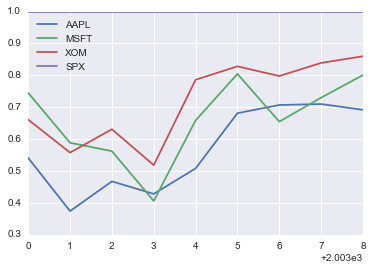

In [123]:
# Extra bonus practice: plot the graph
by_year.apply(spx_corr).plot()

There is, of course, nothing to stop you from computing inter-column correlations:

In [124]:
# Annual correlation of Apple with Microsoft
by_year.apply(lambda g:g['AAPL'].corr(g['MSFT']))

2003    0.480868
2004    0.259024
2005    0.300093
2006    0.161735
2007    0.417738
2008    0.611901
2009    0.432738
2010    0.571946
2011    0.581987
dtype: float64

### Example: Group-wise Linear Regression

In the same vein as the previous example, you can use groupby to perform more complex
group-wise statistical analysis, as long as the function returns a pandas object or scalar
value. For example, I can define the following regress function (using the statsmo
dels econometrics library) which executes an ordinary least squares (OLS) regression
on each chunk of data:

In [125]:
import statsmodels.api as sm
def regress(data, yvar, xvar):
    Y = data[yvar]
    X = data[xvar]
    X['intercept'] = 1
    result = sm.OLS(Y, X).fit()
    return result.params

Now, to run a yearly linear regression of AAPL on SPX returns, I execute:

In [126]:
by_year.apply(regress, 'AAPL', ['SPX'])

,SPX,intercept
2003,1.195406,0.000710
2004,1.363463,0.004201
2005,1.766415,0.003246
2006,1.645496,0.000080
2007,1.198761,0.003438
2008,0.968016,-0.001110
2009,0.879103,0.002954
2010,1.052608,0.001261
2011,0.806605,0.001514


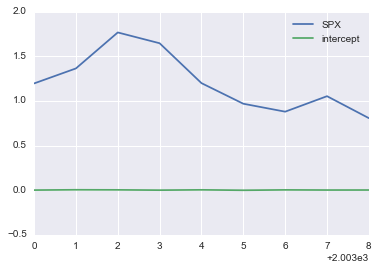

In [127]:
# SPX's beta change during the years as related to AAPL assuming the regression's intercept is 1.
by_year.apply(regress, 'AAPL', ['SPX']).plot()

## Pivot Tables and Cross-Tabulation

A pivot table is a data summarization tool frequently found in spreadsheet programs
and other data analysis software. It aggregates a table of data by one or more keys,
arranging the data in a rectangle with some of the group keys along the rows and some
along the columns. Pivot tables in Python with pandas are made possible using the
groupby facility described in this chapter combined with reshape operations utilizing
hierarchical indexing. DataFrame has a pivot_table method, and additionally there is
a top-level pandas.pivot_table function. In addition to providing a convenience interface
to groupby, pivot_table also can add partial totals, also known as margins.

Returning to the tipping data set, suppose I wanted to compute a table of group means
(the default pivot_table aggregation type) arranged by sex and smoker on the rows:

In [128]:
# Let's take a look first at what tips file is originally
tips.head(5)

,total_bill,tip,sex,smoker,day,time,size,tip_pct
0,16.99,1.01,Female,No,Sun,Dinner,2,0.059447
1,10.34,1.66,Male,No,Sun,Dinner,3,0.160542
2,21.01,3.50,Male,No,Sun,Dinner,3,0.166587
3,23.68,3.31,Male,No,Sun,Dinner,2,0.139780
4,24.59,3.61,Female,No,Sun,Dinner,4,0.146808


In [129]:
# Change the arg "rows" from the textbook to "index" for the python 3 environment.
tips.pivot_table(index = ['sex', 'smoker'])

size       tip   tip_pct  total_bill
sex    smoker                                          
Female No      2.592593  2.773519  0.156921   18.105185
       Yes     2.242424  2.931515  0.182150   17.977879
Male   No      2.711340  3.113402  0.160669   19.791237
       Yes     2.500000  3.051167  0.152771   22.284500

This could have been easily produced using groupby. Now, suppose we want to aggregate
only tip_pct and size, and additionally group by day. I’ll put smoker in the table
columns and day in the rows:

In [130]:
tips.pivot_table(['tip_pct', 'size'], index = ['sex', 'day'],
                columns = 'smoker')

tip_pct                size          
smoker             No       Yes        No       Yes
sex    day                                         
Female Fri   0.165296  0.209129  2.500000  2.000000
       Sat   0.147993  0.163817  2.307692  2.200000
       Sun   0.165710  0.237075  3.071429  2.500000
       Thur  0.155971  0.163073  2.480000  2.428571
Male   Fri   0.138005  0.144730  2.000000  2.125000
       Sat   0.162132  0.139067  2.656250  2.629630
       Sun   0.158291  0.173964  2.883721  2.600000
       Thur  0.165706  0.164417  2.500000  2.300000

This table could be augmented to include partial totals by passing margins=True. This
has the effect of adding All row and column labels, with corresponding values being
the group statistics for all the data within a single tier. In this below example, the All
values are means without taking into account smoker vs. non-smoker (the All columns)
or any of the two levels of grouping on the rows (the All row):

In [131]:
tips.pivot_table(['tip_pct', 'size'], index=['sex', 'day'],
    columns='smoker', margins=True)

tip_pct                          size                    
smoker             No       Yes       All        No       Yes       All
sex    day                                                             
Female Fri   0.165296  0.209129  0.199388  2.500000  2.000000  2.111111
       Sat   0.147993  0.163817  0.156470  2.307692  2.200000  2.250000
       Sun   0.165710  0.237075  0.181569  3.071429  2.500000  2.944444
       Thur  0.155971  0.163073  0.157525  2.480000  2.428571  2.468750
Male   Fri   0.138005  0.144730  0.143385  2.000000  2.125000  2.100000
       Sat   0.162132  0.139067  0.151577  2.656250  2.629630  2.644068
       Sun   0.158291  0.173964  0.162344  2.883721  2.600000  2.810345
       Thur  0.165706  0.164417  0.165276  2.500000  2.300000  2.433333
All          0.159328  0.163196  0.160803  2.668874  2.408602  2.569672

To use a different aggregation function, pass it to aggfunc. For example, 'count' or
len will give you a cross-tabulation (count or frequency) of group sizes:

In [132]:
tips.pivot_table('tip_pct', index=['sex', 'smoker'], columns='day',
     aggfunc=len, margins=True)

day             Fri   Sat   Sun  Thur    All
sex    smoker                               
Female No       2.0  13.0  14.0  25.0   54.0
       Yes      7.0  15.0   4.0   7.0   33.0
Male   No       2.0  32.0  43.0  20.0   97.0
       Yes      8.0  27.0  15.0  10.0   60.0
All            19.0  87.0  76.0  62.0  244.0

If some combinations are empty (or otherwise NA), you may wish to pass a fill_value:

In [133]:
tips.pivot_table('size', index=['time', 'sex', 'smoker'],
    columns='day', aggfunc='sum', fill_value=0)

day                   Fri  Sat  Sun  Thur
time   sex    smoker                     
Dinner Female No        2   30   43     2
              Yes       8   33   10     0
       Male   No        4   85  124     0
              Yes      12   71   39     0
Lunch  Female No        3    0    0    60
              Yes       6    0    0    17
       Male   No        0    0    0    50
              Yes       5    0    0    23

See Table 9-2 for a summary of pivot_table methods.

Table 9-2. pivot_table options

Function name Description

values: Column name or names to aggregate. By default aggregates all numeric columns

rows(index in python 3): Column names or other group keys to group on the rows of the resulting pivot table

cols(columns in python 3): Column names or other group keys to group on the columns of the resulting pivot table

aggfunc: Aggregation function or list of functions; 'mean' by default. Can be any function valid in a groupby context

fill_value: Replace missing values in result table

margins: Add row/column subtotals and grand total, False by default

### Cross-Tabulations: Crosstab

A cross-tabulation (or crosstab for short) is a special case of a pivot table that computes
group frequencies. Here is a canonical example taken from the Wikipedia page on crosstabulation:

In [134]:
hdns = pd.read_csv('handedness.csv')
hdns

,Unnamed: 0,Sample,Gender,Handedness
0,0,1,Female,Right-handed
1,1,2,Male,Left-handed
2,2,3,Female,Right-handed
3,3,4,Male,Right-handed
4,4,5,Male,Left-handed
5,5,6,Male,Right-handed
6,6,7,Female,Right-handed
7,7,8,Female,Left-handed
8,8,9,Male,Right-handed
9,9,10,Female,Right-handed


As part of some survey analysis, we might want to summarize this data by gender and
handedness. You could use pivot_table to do this, but the pandas.crosstab function
is very convenient:

In [135]:
pd.crosstab(hdns['Gender'], hdns['Handedness'], margins = True)

Handedness,Left-handed,Right-handed,All
Gender,,,
Female,1,4,5
Male,2,3,5
All,3,7,10


In [136]:
# Two expressions function the same way, the above is my own. Below is the one from textbook.
pd.crosstab(hdns.Gender, hdns.Handedness, margins = True)

Handedness,Left-handed,Right-handed,All
Gender,,,
Female,1,4,5
Male,2,3,5
All,3,7,10


The first two arguments to crosstab can each either be an array or Series or a list of
arrays. As in the tips data:

In [137]:
pd.crosstab([tips.time, tips.day], tips.smoker, margins=True)

smoker        No  Yes  All
time   day                
Dinner Fri     3    9   12
       Sat    45   42   87
       Sun    57   19   76
       Thur    1    0    1
Lunch  Fri     1    6    7
       Thur   44   17   61
All          151   93  244

## Example: 2012 Federal Election Commission Database

The US Federal Election Commission publishes data on contributions to political campaigns.
This includes contributor names, occupation and employer, address, and contribution
amount. An interesting dataset is from the 2012 US presidential election
(http://www.fec.gov/disclosurep/PDownload.do). As of this writing (June 2012), the full
dataset for all states is a 150 megabyte CSV file P00000001-ALL.csv, which can be loaded
with pandas.read_csv:

In [138]:
fec = pd.read_csv('P00000001-ALL.csv', low_memory = False)
fec

,cmte_id,cand_id,cand_nm,contbr_nm,contbr_city,contbr_st,contbr_zip,contbr_employer,contbr_occupation,contb_receipt_amt,contb_receipt_dt,receipt_desc,memo_cd,memo_text,form_tp,file_num
0,C00410118,P20002978,"Bachmann, Michelle","HARVEY, WILLIAM",MOBILE,AL,366010290,RETIRED,RETIRED,250.0,20-JUN-11,NaN,NaN,NaN,SA17A,736166
1,C00410118,P20002978,"Bachmann, Michelle","HARVEY, WILLIAM",MOBILE,AL,366010290,RETIRED,RETIRED,50.0,23-JUN-11,NaN,NaN,NaN,SA17A,736166
2,C00410118,P20002978,"Bachmann, Michelle","SMITH, LANIER",LANETT,AL,368633403,INFORMATION REQUESTED,INFORMATION REQUESTED,250.0,05-JUL-11,NaN,NaN,NaN,SA17A,749073
3,C00410118,P20002978,"Bachmann, Michelle","BLEVINS, DARONDA",PIGGOTT,AR,724548253,NONE,RETIRED,250.0,01-AUG-11,NaN,NaN,NaN,SA17A,749073
4,C00410118,P20002978,"Bachmann, Michelle","WARDENBURG, HAROLD",HOT SPRINGS NATION,AR,719016467,NONE,RETIRED,300.0,20-JUN-11,NaN,NaN,NaN,SA17A,736166
5,C00410118,P20002978,"Bachmann, Michelle","BECKMAN, JAMES",SPRINGDALE,AR,727647190,NONE,RETIRED,500.0,23-JUN-11,NaN,NaN,NaN,SA17A,736166
6,C00410118,P20002978,"Bachmann, Michelle","BLEVINS, DARONDA",PIGGOTT,AR,724548253,INFORMATION REQUESTED,INFORMATION REQUESTED,250.0,21-JUN-11,NaN,NaN,NaN,SA17A,736166
7,C00410118,P20002978,"Bachmann, Michelle","BLEVINS, DARONDA",PIGGOTT,AR,724548253,NONE,RETIRED,250.0,05-JUL-11,NaN,NaN,NaN,SA17A,749073
8,C00410118,P20002978,"Bachmann, Michelle","COLLINS, SARAH",MESA,AZ,852106725,ST. JOSEPH HOSPITAL,RN,250.0,21-JUN-11,NaN,NaN,NaN,SA17A,736166
9,C00410118,P20002978,"Bachmann, Michelle","COLEMAN, RONALD",TUCSON,AZ,857498865,RAYTHEON,ELECTRICAL ENGINEER,250.0,20-JUN-11,NaN,NaN,NaN,SA17A,736166


A sample record in the DataFrame looks like this:

In [139]:
fec.ix[123456]

cmte_id                             C00431445
cand_id                             P80003338
cand_nm                         Obama, Barack
contbr_nm                         ELLMAN, IRA
contbr_city                             TEMPE
contbr_st                                  AZ
contbr_zip                          852816719
contbr_employer      ARIZONA STATE UNIVERSITY
contbr_occupation                   PROFESSOR
contb_receipt_amt                          50
contb_receipt_dt                    01-DEC-11
receipt_desc                              NaN
memo_cd                                   NaN
memo_text                                 NaN
form_tp                                 SA17A
file_num                               772372
Name: 123456, dtype: object

You can probably think of many ways to start slicing and dicing this data to extract
informative statistics about donors and patterns in the campaign contributions. I’ll
spend the next several pages showing you a number of different analyses that apply
techniques you have learned about so far.
You can see that there are no political party affiliations in the data, so this would be
useful to add. You can get a list of all the unique political candidates using unique (note
that NumPy suppresses the quotes around the strings in the output):

In [140]:
unique_cands = fec.cand_nm.unique()
unique_cands

array(['Bachmann, Michelle', 'Romney, Mitt', 'Obama, Barack',
       "Roemer, Charles E. 'Buddy' III", 'Pawlenty, Timothy',
       'Johnson, Gary Earl', 'Paul, Ron', 'Santorum, Rick', 'Cain, Herman',
       'Gingrich, Newt', 'McCotter, Thaddeus G', 'Huntsman, Jon',
       'Perry, Rick'], dtype=object)

In [141]:
unique_cands[2]

'Obama, Barack'

An easy way to indicate party affiliation is using a dict:2

In [142]:
# 2. This makes the simplifying assumption that Gary Johnson is a Republican even though he later became
# the Libertarian party candidate.
parties = {'Bachmann, Michelle': 'Republican',
'Cain, Herman': 'Republican',
'Gingrich, Newt': 'Republican',
'Huntsman, Jon': 'Republican',
'Johnson, Gary Earl': 'Republican',
'McCotter, Thaddeus G': 'Republican',
'Obama, Barack': 'Democrat',
'Paul, Ron': 'Republican',
'Pawlenty, Timothy': 'Republican',
'Perry, Rick': 'Republican',
"Roemer, Charles E. 'Buddy' III": 'Republican',
'Romney, Mitt': 'Republican',
'Santorum, Rick': 'Republican'}

Now, using this mapping and the map method on Series objects, you can compute an
array of political parties from the candidate names:

In [143]:
fec.cand_nm[123456:123462]

123456    Obama, Barack
123457    Obama, Barack
123458    Obama, Barack
123459    Obama, Barack
123460    Obama, Barack
123461    Obama, Barack
Name: cand_nm, dtype: object

In [144]:
fec.cand_nm[123456:123461].map(parties)

123456    Democrat
123457    Democrat
123458    Democrat
123459    Democrat
123460    Democrat
Name: cand_nm, dtype: object

In [145]:
# Add it as a column
fec['party'] = fec.cand_nm.map(parties)

In [146]:
fec['party'].value_counts()

Democrat      593746
Republican    407985
Name: party, dtype: int64

A couple of data preparation points. First, this data includes both contributions and
refunds (negative contribution amount):

In [147]:
(fec.contb_receipt_amt > 0).value_counts()

True     991475
False     10256
Name: contb_receipt_amt, dtype: int64

To simplify the analysis, I’ll restrict the data set to positive contributions:

In [148]:
fec = fec[fec.contb_receipt_amt > 0]

Since Barack Obama and Mitt Romney are the main two candidates, I’ll also prepare
a subset that just has contributions to their campaigns:

In [149]:
fec_mrbo = fec[fec.cand_nm.isin(['Obama, Barack', 'Romney, Mitt'])]
fec_mrbo

,cmte_id,cand_id,cand_nm,contbr_nm,contbr_city,contbr_st,contbr_zip,contbr_employer,contbr_occupation,contb_receipt_amt,contb_receipt_dt,receipt_desc,memo_cd,memo_text,form_tp,file_num,party
411,C00431171,P80003353,"Romney, Mitt","ELDERBAUM, WILLIAM",DPO,AA,340230183,US GOVERNMENT,FOREIGN SERVICE OFFICER,25.0,01-FEB-12,NaN,NaN,NaN,SA17A,780124,Republican
412,C00431171,P80003353,"Romney, Mitt","ELDERBAUM, WILLIAM",DPO,AA,340230183,US GOVERNMENT,FOREIGN SERVICE OFFICER,110.0,01-FEB-12,NaN,NaN,NaN,SA17A,780124,Republican
413,C00431171,P80003353,"Romney, Mitt","CARLSEN, RICHARD",APO,AE,091280020,DEFENSE INTELLIGENCE AGENCY,INTELLIGENCE ANALYST,250.0,13-APR-12,NaN,NaN,NaN,SA17A,785689,Republican
414,C00431171,P80003353,"Romney, Mitt","DELUCA, PIERRE",APO,AE,091280005,CISCO,ENGINEER,30.0,21-AUG-11,NaN,NaN,NaN,SA17A,760261,Republican
415,C00431171,P80003353,"Romney, Mitt","SARGENT, MICHAEL",APO,AE,090120092,RAYTHEON TECHNICAL SERVICES CORP,COMPUTER SYSTEMS ENGINEER,100.0,07-MAR-12,NaN,NaN,NaN,SA17A,780128,Republican
416,C00431171,P80003353,"Romney, Mitt","WILSON, ANDREW C. MR.",DPO,AE,098700023,US DEPT OF STATE,FOREIGN SERVICE OFFICER,50.0,17-MAR-12,NaN,NaN,NaN,SA17A,780128,Republican
417,C00431171,P80003353,"Romney, Mitt","GRIFFIS, JOHN",APO,AE,091280011,US ARMY,MILITARY OFFICER,250.0,20-MAR-12,NaN,NaN,NaN,SA17A,780128,Republican
418,C00431171,P80003353,"Romney, Mitt","SARGENT, MICHAEL",APO,AE,090120092,RAYTHEON TECHNICAL SERVICES CORP,COMPUTER SYSTEMS ENGINEER,100.0,09-APR-12,NaN,NaN,NaN,SA17A,785689,Republican
419,C00431171,P80003353,"Romney, Mitt","GRIFFIS, JOHN",APO,AE,091280011,US ARMY,MILITARY OFFICER,250.0,28-JAN-12,NaN,NaN,NaN,SA17A,771933,Republican
420,C00431171,P80003353,"Romney, Mitt","DELUCA, PIERRE MR.",APO,AE,091280005,US ARMY,ENGINEER,50.0,01-FEB-12,NaN,NaN,NaN,SA17A,780124,Republican


### Donation Statistics by Occupation and Employers

Donations by occupation is another oft-studied statistic. For example, lawyers (attorneys)
tend to donate more money to Democrats, while business executives tend to
donate more to Republicans. You have no reason to believe me; you can see for yourself
in the data. First, the total number of donations by occupation is easy:

In [150]:
fec.contbr_occupation.value_counts()

RETIRED                                   233990
INFORMATION REQUESTED                      35107
ATTORNEY                                   34286
HOMEMAKER                                  29931
PHYSICIAN                                  23432
INFORMATION REQUESTED PER BEST EFFORTS     21138
ENGINEER                                   14334
TEACHER                                    13990
CONSULTANT                                 13273
PROFESSOR                                  12555
NOT EMPLOYED                                9828
SALES                                       8333
LAWYER                                      8283
MANAGER                                     8024
PRESIDENT                                   7758
STUDENT                                     7071
OWNER                                       6343
EXECUTIVE                                   5506
SELF-EMPLOYED                               5472
WRITER                                      5128
SOFTWARE ENGINEER   

You will notice by looking at the occupations that many refer to the same basic job
type, or there are several variants of the same thing. Here is a code snippet illustrates a
technique for cleaning up a few of them by mapping from one occupation to another;
note the “trick” of using dict.get to allow occupations with no mapping to “pass
through”:

In [151]:
occ_mapping = {
'INFORMATION REQUESTED PER BEST EFFORTS' : 'NOT PROVIDED',
'INFORMATION REQUESTED' : 'NOT PROVIDED',
'INFORMATION REQUESTED (BEST EFFORTS)' : 'NOT PROVIDED',
'C.E.O.': 'CEO'
}

In [152]:
# If no mapping provided, return 
f = lambda x: occ_mapping.get(x, x)
fec.contbr_occupation = fec.contbr_occupation.map(f)
fec.contbr_occupation

C:\Users\Brad Sun\Anaconda3\lib\site-packages\pandas\core\generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


0                               RETIRED
1                               RETIRED
2                          NOT PROVIDED
3                               RETIRED
4                               RETIRED
5                               RETIRED
6                          NOT PROVIDED
7                               RETIRED
8                                    RN
9                   ELECTRICAL ENGINEER
10                              RETIRED
11                       LAND DEVELOPER
12                         NOT PROVIDED
13                         NOT PROVIDED
14                         NOT PROVIDED
15                            PHYSICIAN
16                              RETIRED
17                              RETIRED
18                              RETIRED
19                              RETIRED
20              OFFICE FURNITURE BROKER
21                              RETIRED
22                              MANAGER
23                              MANAGER
24                              RETIRED


I’ll also do the same thing for employers:

In [153]:
emp_mapping = {
'INFORMATION REQUESTED PER BEST EFFORTS' : 'NOT PROVIDED',
'INFORMATION REQUESTED' : 'NOT PROVIDED',
'SELF' : 'SELF-EMPLOYED',
'SELF EMPLOYED' : 'SELF-EMPLOYED',
}

In [154]:
# If no mapping provided, return x
f = lambda x: emp_mapping.get(x, x)
fec.contbr_employer = fec.contbr_employer.map(f)

C:\Users\Brad Sun\Anaconda3\lib\site-packages\pandas\core\generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [156]:
by_occupation = fec.pivot_table('contb_receipt_amt',
                               index = 'contbr_occupation', 
                               columns = 'party', aggfunc = 'sum')

In [157]:
over_2mm = by_occupation[by_occupation.sum(1) > 2000000]

In [161]:
over_2mm

party,Democrat,Republican
contbr_occupation,,
ATTORNEY,11141982.97,7.477194e+06
CEO,2074974.79,4.211041e+06
CONSULTANT,2459912.71,2.544725e+06
ENGINEER,951525.55,1.818374e+06
EXECUTIVE,1355161.05,4.138850e+06
HOMEMAKER,4248875.80,1.363428e+07
INVESTOR,884133.00,2.431769e+06
LAWYER,3160478.87,3.912243e+05
MANAGER,762883.22,1.444532e+06


It can be easier to look at this data graphically as a bar plot ('barh' means horizontal
bar plot, see Figure 9-2):

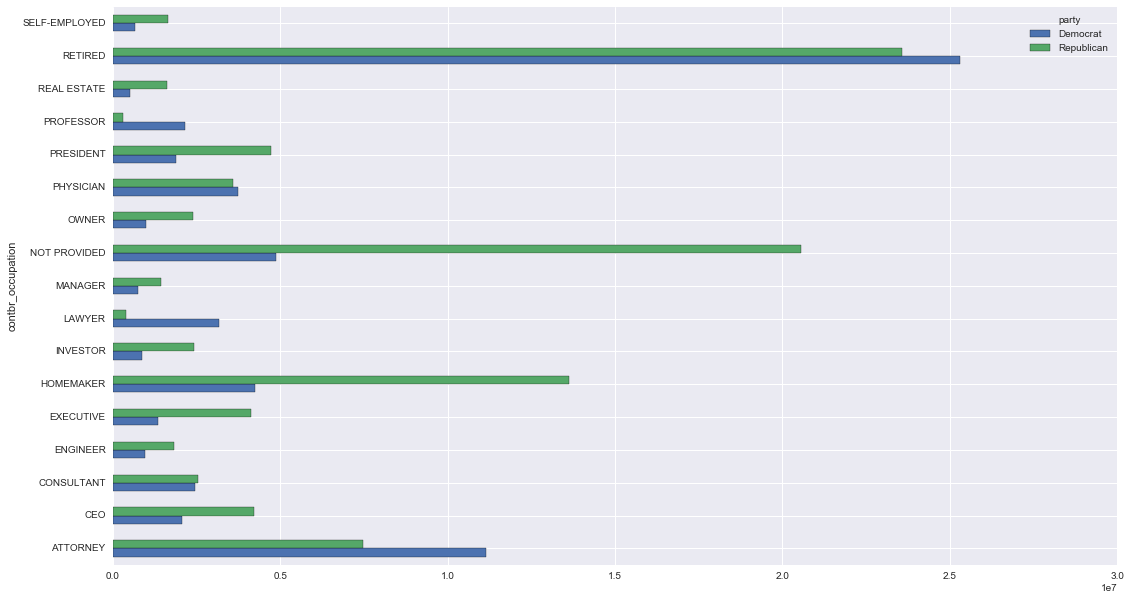

In [164]:
over_2mm.plot(kind = 'barh', figsize = (18,10))

You might be interested in the top donor occupations or top companies donating to
Obama and Romney. To do this, you can group by candidate name and use a variant
of the top method from earlier in the chapter:

In [221]:
def get_top_amounts(group, key, n=5):
    totals = group.groupby(key)['contb_receipt_amt'].sum()
    # Order totals by key in descending order
    return totals.order(ascending = False)[-n:]

Then aggregated by occupation and employer:

In [222]:
grouped = fec_mrbo.groupby('cand_nm')

In [223]:
grouped.apply(get_top_amounts, 'contbr_occupation', n=7)

C:\Users\Brad Sun\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: order is deprecated, use sort_values(...)


cand_nm        contbr_occupation                     
Obama, Barack  COMPUTER ASSISTANT                        3.0
               SPRINKLER FITTER FIRE PROTECTION SPECI    3.0
               ADMINISTRATION/INSTRUCTOR                 3.0
               LEAD UI/UX DEVELOPER                      3.0
               POLICY/ LAWYER                            3.0
               LAN/WAN ANALYST                           3.0
               SR MGR                                    3.0
Romney, Mitt   MD - UROLOGIST                            5.0
               DISTRICT REPRESENTATIVE                   5.0
               INDEPENDENT PROFESSIONAL                  3.0
               REMODELER & SEMI RETIRED                  3.0
               AFFORDABLE REAL ESTATE DEVELOPER          3.0
               IFC CONTRACTING SOLUTIONS                 3.0
               3RD GENERATION FAMILY BUSINESS OWNER      3.0
Name: contb_receipt_amt, dtype: float64

In [225]:
grouped.apply(get_top_amounts, 'contbr_employer', n=10)

C:\Users\Brad Sun\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: order is deprecated, use sort_values(...)


cand_nm        contbr_employer                   
Obama, Barack  SOLIYA                                3.0
               CARR ENTERPRISES                      3.0
               PENN STATE DICKINSON SCHOOL OF LAW    3.0
               CADUCEUS OCCUPATIONAL MEDICINE        3.0
               N.A.                                  3.0
               REAL ENERGY CONSULTING SERVICES       3.0
               JPDSYSTEMS, LLC                       3.0
               CASS REGIONAL MED. CENTER             2.5
               ARCON CORP                            2.0
               THE VICTORIA GROUP, INC.              2.0
Romney, Mitt   EASTHAM CAPITAL                       5.0
               GREGORY GALLIVAN                      5.0
               DIRECT LENDERS LLC                    5.0
               LOUGH INVESTMENT ADVISORY LLC         4.0
               WATERWORKS INDUSRTIES                 3.0
               WILL MERRIFIELD                       3.0
               HONOLD COMMUNICTAIONS  

### Bucketing Donation Amounts

A useful way to analyze this data is to use the cut function to discretize the contributor
amounts into buckets by contribution size:

In [226]:
bins = np.array([0, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000])

In [227]:
labels = pd.cut(fec_mrbo.contb_receipt_amt, bins)

In [228]:
labels

411           (10, 100]
412         (100, 1000]
413         (100, 1000]
414           (10, 100]
415           (10, 100]
416           (10, 100]
417         (100, 1000]
418           (10, 100]
419         (100, 1000]
420           (10, 100]
421           (10, 100]
422         (100, 1000]
423         (100, 1000]
424         (100, 1000]
425         (100, 1000]
426         (100, 1000]
427       (1000, 10000]
428         (100, 1000]
429         (100, 1000]
430           (10, 100]
431       (1000, 10000]
432         (100, 1000]
433         (100, 1000]
434         (100, 1000]
435         (100, 1000]
436         (100, 1000]
437           (10, 100]
438         (100, 1000]
439         (100, 1000]
440           (10, 100]
              ...      
701356        (10, 100]
701357          (1, 10]
701358        (10, 100]
701359        (10, 100]
701360        (10, 100]
701361        (10, 100]
701362      (100, 1000]
701363        (10, 100]
701364        (10, 100]
701365        (10, 100]
701366        (1

We can then group the data for Obama and Romney by name and bin label to get a
histogram by donation size:

In [230]:
grouped = fec_mrbo.groupby(['cand_nm', labels])

In [231]:
# Number of people
grouped.size().unstack(0)

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",493.0,77.0
"(1, 10]",40070.0,3681.0
"(10, 100]",372280.0,31853.0
"(100, 1000]",153991.0,43357.0
"(1000, 10000]",22284.0,26186.0
"(10000, 100000]",2.0,1.0
"(100000, 1000000]",3.0,NaN
"(1000000, 10000000]",4.0,NaN


This data shows that Obama has received a significantly larger number of small donations
than Romney. You can also sum the contribution amounts and normalize within
buckets to visualize percentage of total donations of each size by candidate:

In [232]:
bucket_sums = grouped.contb_receipt_amt.sum().unstack(0)

In [233]:
# In dollars
bucket_sums

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",318.24,77.00
"(1, 10]",337267.62,29819.66
"(10, 100]",20288981.41,1987783.76
"(100, 1000]",54798531.46,22363381.69
"(1000, 10000]",51753705.67,63942145.42
"(10000, 100000]",59100.00,12700.00
"(100000, 1000000]",1490683.08,NaN
"(1000000, 10000000]",7148839.76,NaN


In [234]:
# Code for Normalization and Visualization Process
# Divide each row's number by the sum of each row's two numbers
normed_sums = bucket_sums.div(bucket_sums.sum(axis=1), axis=0)

In [235]:
normed_sums

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",0.805182,0.194818
"(1, 10]",0.918767,0.081233
"(10, 100]",0.910769,0.089231
"(100, 1000]",0.710176,0.289824
"(1000, 10000]",0.447326,0.552674
"(10000, 100000]",0.823120,0.176880
"(100000, 1000000]",1.000000,NaN
"(1000000, 10000000]",1.000000,NaN


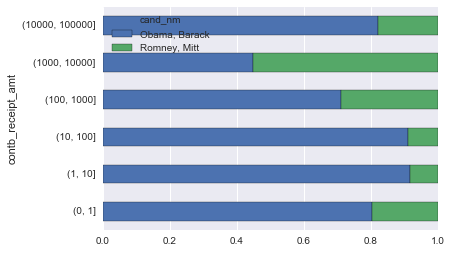

In [246]:
normed_sums[:-2].plot(kind='barh', stacked=True)


There are of course many refinements and improvements of this analysis. For example,
you could aggregate donations by donor name and zip code to adjust for donors who
gave many small amounts versus one or more large donations. I encourage you to
download it and explore it yourself.

### Donation Statistics by State

Aggregating the data by candidate and state is a routine affair:

In [247]:
grouped = fec_mrbo.groupby(['cand_nm', 'contbr_st'])

In [248]:
totals = grouped.contb_receipt_amt.sum().unstack(0).fillna(0)

In [249]:
totals = totals[totals.sum(1) > 100000]

In [250]:
totals[:10]

cand_nm,"Obama, Barack","Romney, Mitt"
contbr_st,,
AK,281840.15,86204.24
AL,543123.48,527303.51
AR,359247.28,105556.00
AZ,1506476.98,1888436.23
CA,23824984.24,11237636.60
CO,2132429.49,1506714.12
CT,2068291.26,3499475.45
DC,4373538.80,1025137.50
DE,336669.14,82712.00


If you divide each row by the total contribution amount, you get the relative percentage
of total donations by state for each candidate:

In [255]:
percent = totals.div(totals.sum(1), axis=0)

In [256]:
percent[:10]

cand_nm,"Obama, Barack","Romney, Mitt"
contbr_st,,
AK,0.765778,0.234222
AL,0.507390,0.492610
AR,0.772902,0.227098
AZ,0.443745,0.556255
CA,0.679498,0.320502
CO,0.585970,0.414030
CT,0.371476,0.628524
DC,0.810113,0.189887
DE,0.802776,0.197224


I thought it would be interesting to look at this data plotted on a map, using ideas from
Chapter 8. After locating a shape file for the state boundaries (http://nationalatlas.gov/
atlasftp.html?openChapters=chpbound) and learning a bit more about matplotlib and
its basemap toolkit (I was aided by a blog posting from Thomas Lecocq)3, I ended up
with the following code for plotting these relative percentages:

In [263]:
from mpl_toolkits.basemap import Basemap
import numpy as np
from matplotlib import rcParams
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
from shapelib import ShapeFile
import dbflib

ImportError: No module named 'mpl_toolkits.basemap'

In [ ]:
obama = percent['Obama, Barack']

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_axes([0.1,0.1,0.8,0.8])

In [ ]:
lllat = 21; urlat = 53; lllon = -118; urlon = -62

In [ ]:
m = Basemap(ax=ax, projection='stere',
    lon_0=(urlon + lllon) / 2, lat_0=(urlat + lllat) / 2,
    llcrnrlat=lllat, urcrnrlat=urlat, llcrnrlon=lllon,
    urcrnrlon=urlon, resolution='l')
m.drawcoastlines()
m.drawcountries()

In [ ]:
shp = ShapeFile('../states/statesp020')
dbf = dbflib.open('../states/statesp020')

In [ ]:
for npoly in range(shp.info()[0]):
    # Draw colored polygons on the map
    shpsegs = []
    shp_object = shp.read_object(npoly)
    verts = shp_object.vertices()
    rings = len(verts)
    for ring in range(rings):
        lons, lats = zip(*verts[ring])
        x, y = m(lons, lats)
        shpsegs.append(zip(x,y))
        if ring == 0:
            shapedict = dbf.read_record(npoly)
        name = shapedict['STATE']
    lines = LineCollection(shpsegs,antialiaseds=(1,))
    # state_to_code dict, e.g. 'ALASKA' -> 'AK', omitted
    try:
        per = obama[state_to_code[name.upper()]]
    except KeyError:
        continue

    lines.set_facecolors('k')
    lines.set_alpha(0.75 * per) # Shrink the percentage a bit
    lines.set_edgecolors('k')
    lines.set_linewidth(0.3)
    ax.add_collection(lines)
plt.show()
#Figure 9-4. US map aggregated donation statistics overlay (darker means more Democratic)